In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

# Queueing simulation with antithetic draws

In [2]:
def exponential_rng(lam, u):  
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
        u (float): Uniform random number.
    
    Returns:
        exponential random number with given rate.
    """
    return -np.log(u) / lam

In [3]:
class Event:
    """ Generic event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        self.time = time
        
class Generation(Event):
    """ Generation event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Arrival(Event):
    """ Arrival event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Departure(Event):
    """ Departure event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Termination(Event):
    """ Termination event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)

In [4]:
class Scenario:
    """ Road scenario
    
    Attributes:
        demand duration (float): Duration of vehicle generation.
        t0 (float): Free-flow travel time.
        lam (float): Entry rate.
        mu (float): Service rate.
    """
    
    def __init__(self, 
                 demand_duration = 50.0,
                 t0 = 1.0,
                 lam = 1.0,
                 mu = 1.0,
                ):
        self.demand_duration = demand_duration
        self.t0 = t0
        self.lam = lam
        self.mu = mu

In [5]:
def simulate(scenario, u):
    """ Implements the simulation procedure.
    
    K
    eywords:
        scenario (Scenario): Road scenario.
        u (array): 3 x N array of uniform random numbers, N must be sufficiently large.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
    """
    
    # Initialise the simulation
    queue = 0 # Current queue length: auxiliary variable
    times = [0]
    queues = [0]
    
    # Use different streams of random numbers for different event types
    iGen, iArr, iDep = (0 for i in range(3))
    
    # Trigger the first events
    # print('Start of generation')
    generation = Generation(exponential_rng(scenario.lam, u[0, iGen]))
    iGen += 1
    termination = Termination(scenario.demand_duration)
    events = [generation, termination]
    
    # Main loop
    while len(events):
        e = events[0] # Extract the first event from the queue (event list)
        
        # Switch statement: execute one code block among many alternatives according to the event type
        if isinstance(e, Generation):
            # print('Generation')
            
            # Schedule arrival of the vehicle
            arrival = Arrival(e.time + scenario.t0 * u[1, iArr])
            iArr += 1
            events.append(arrival)
            
            # Schedule the next generation
            next_generation_time = e.time + exponential_rng(scenario.lam, u[0, iGen])
            iGen += 1
            if next_generation_time < scenario.demand_duration: # Add to the queue only if event time is smaller than the duration period
                generation = Generation(next_generation_time)
                events.append(generation)
                
        elif isinstance(e, Arrival):
            # print('Arrival')
            
            # Update state variables
            times.append(e.time)
            queue += 1 # Increment the current queue length by 1...
            queues.append(queue) # ...and store the new value
            
            # Schedule the departure of the vehicle just arrived, if the queue was empty
            if queue == 1:
                departure = Departure(e.time + exponential_rng(scenario.mu, u[2, iDep]))
                iDep += 1
                events.append(departure)
                
        elif isinstance(e, Departure):
            # print('Departure')
            
            # Update state variables
            times.append(e.time)
            queue -= 1 # Decrement the current queue length by 1...
            queues.append(queue) # ...and store the new value
            
            # Schedule the next departure, if there are other vehicles waiting
            if queue:
                departure = Departure(e.time + exponential_rng(scenario.mu, u[2, iDep]))
                iDep += 1
                events.append(departure)
                
        elif isinstance(e, Termination):
            # print('End of generation')
            pass
        
        else:
            raise('Unknown event type!')
            
        events.pop(0) # Remove the first event from the list
        events.sort(key = lambda event: event.time)
        
    return times, queues

In [6]:
def moving_mean_var(new_data, old_mean, old_var, t):
    """ Calculates moving sameple mean and variance at time t.
    
    Keywords:
        new_data (float): new data point arriving at time t.
        old_mean (float): previous sample mean.
        old_var (float): previous sample variance.
        t (int): time index
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """
    if t == 1: # Modified with respect to the notebook of laboratory 3 so that it is consistent with the code that follows 
        new_mean = new_data
        new_var = 0
    else:
        new_mean = old_mean + (new_data - old_mean)/ t
        new_var = (1 - 1/(t-1))*old_var + t*(new_mean - old_mean)**2
    return new_mean, new_var

### Independent runs

In [7]:
# Requested precision for the estimation of the average maximum queue length. 
# Empirically calculated such that approximately 100 simulation runs are necessary.
precision = 0.1

max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
run = 0

scenario = Scenario()

# Main loop
while True:
    run += 1
    
    # Run simulation
    u = np.random.rand(3, 1000)
    queues = simulate(scenario, u)[1]
    max_queue = max(queues)
    
    # Collect statistics
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean, max_queue_var, run)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)
    
    # Check if necessary precision reached (complete an even number of iterations for convenience)
    if run >= 100 and (run % 2 == 0) and np.sqrt(max_queue_var / run) < precision:
        break
        
sd_independent = np.sqrt(max_queue_var_all)

### Antithetic runs

In [8]:
max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
scenario = Scenario()

# Main loop
for r in range(int(run/2)):
    
    # Independent simulation
    u = np.random.rand(3, 1000)
    queues = simulate(scenario, u)[1]
    max_queue_ind = max(queues)
    
    # Antithetic simulation
    u = 1 - u
    queues = simulate(scenario, u)[1]
    max_queue_ant = max(queues)
    
    # Collect statistics
    max_queue = (max_queue_ind + max_queue_ant)/2
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean, max_queue_var, r+1)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)

sd_antithetic = np.sqrt(max_queue_var_all)

Plot the standard deviation of maximum queue length.

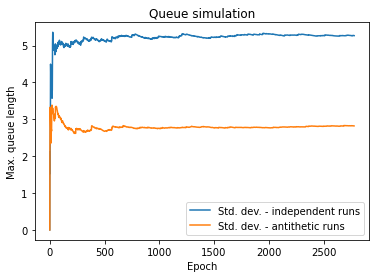

In [9]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)

ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.plot(np.arange(0,sd_independent.shape[0],2), sd_antithetic, label='Std. dev. - antithetic runs')
ax.set(title='Queue simulation',
       xlabel='Epoch',
       ylabel='Max. queue length')
ax.legend()
# fig.savefig('figure_antithetic.pdf', dpi=300)
plt.show()

# Queueing simulation with control variates

In [10]:
def controlled_mean(x, y, mu):
    """ Calculates the controlled mean.
    
    Keywords:
        x (array): Data.
        y (array): Control data.
        mu (float): Scalar expectation of the control data.
    
    Returns:
        avg (float): Controlled mean of the data.
        var (float): Variance of the controlled mean.
        z (array): Optimal linear combination of the data and the control data. 
    """

    cov = np.cov(x, y)
    c_star = -cov[0, 1]/cov[1, 1] # Covariance between x and y divided by the variance of y  
    
    z = x + c_star*(y - mu)
    avg = z.mean()
    var = z.var()
    
    return avg, var, z

In [11]:
def simulate(scenario):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Road scenario.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
        service_time_mean (float): Mean service time
    """
    
    # Initialise the simulation
    queue = 0
    times = [0]
    queues = [0]
    service_times = []
    
    # Trigger the first events
    # print('Start of generation')
    generation = Generation(exponential_rng(scenario.lam, np.random.rand()))
    termination = Termination(scenario.demand_duration)
    events = [generation, termination]
    
    # Main loop
    while len(events):
        e = events[0] # Extract the first event from the queue (event list)
        
        # Switch statement: execute one code block among many alternatives according to the event type
        if isinstance(e, Generation):
            # print('Generation')
            
            # Schedule arrival of the vehicle
            arrival = Arrival(e.time + scenario.t0 * np.random.rand())
            events.append(arrival)
            
            # Schedule the next generation
            next_generation_time = e.time + exponential_rng(scenario.lam, np.random.rand())
            if next_generation_time < scenario.demand_duration: # Add to the queue only if event time is smaller than the duration period
                generation = Generation(next_generation_time)
                events.append(generation)
                
        elif isinstance(e, Arrival):
            # print('Arrival')
            
            # Update state variables
            times.append(e.time)
            queue += 1 # Increment the current queue length by 1...
            queues.append(queue) # ...and store the new value
            
            # Schedule the departure of the vehicle just arrived, if the queue was empty
            if queue == 1:            
                service_times.append(exponential_rng(scenario.mu, np.random.rand()))
                departure = Departure(e.time + service_times[-1])
                events.append(departure)
                
        elif isinstance(e, Departure):
            # print('Departure')
            
            # Update state variables
            times.append(e.time)
            queue -= 1 # Decrement the current queue length by 1...
            queues.append(queue) # ...and store the new value
            
            # Schedule the next departure, if there are other vehicles waiting
            if queue:
                service_times.append(exponential_rng(scenario.mu, np.random.rand()))
                departure = Departure(e.time + service_times[-1])
                events.append(departure)
                
        elif isinstance(e, Termination):
            # print('End of generation')
            pass
        
        else:
            raise('Unknown event type!')
            
        events.pop(0) # Remove the first event from the list
        events.sort(key = lambda event: event.time)
    
    # Compute the average service time
    service_time_mean = sum(service_times)/len(service_times)
    
    return times, queues, service_time_mean

In [12]:
# Requested precision for the estimation of the average maximum queue length. 
# Empirically calculated such that approximately 100 simulation runs are necessary.
precision = 0.1

max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
service_time_mean_all = []
max_queue_var_control_all = []

scenario = Scenario()

# Main loop
for r in range(run):
    # Run simulator
    queues, service_time_mean = simulate(scenario)[1:]
    max_queue = max(queues)
    service_time_mean_all.append(service_time_mean)

    
    # Collect statistics
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean, max_queue_var, r+1)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)
    
    if r == 0:
        max_queue_var_control = max_queue_var
    else:
        max_queue_var_control = controlled_mean(np.array(max_queue_all), np.array(service_time_mean_all), 1/scenario.mu)[1]
    max_queue_var_control_all.append(max_queue_var_control)
    
sd_control = np.sqrt(max_queue_var_control_all)

Information on correlation

In [13]:
np.corrcoef(service_time_mean_all, max_queue_all)

array([[1.       , 0.4458797],
       [0.4458797, 1.       ]])

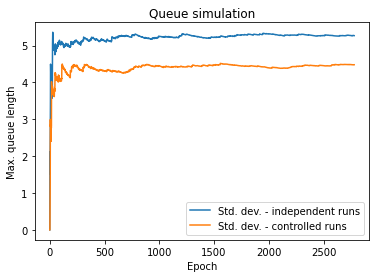

In [14]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.plot(sd_control, label='Std. dev. - controlled runs')
ax.set(title='Queue simulation',
       xlabel='Epoch',
       ylabel='Max. queue length')
ax.legend()
# fig.savefig('figure_control_variates.pdf', dpi=300)
plt.show()